## 0. Basic
[Reference](https://github.com/Nhan121/Kaggle-6-first-projects/blob/master/Prostate%20cANcer%20graDe%20Assessment%20(PANDA)%20Challenge/U-net_model%20(train_loss).ipynb)
### Display the some first `image_file_names` & `file_name.csv`

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# print out the names of the first 2 image_files (total = 4 images for train_imgaes & train_label_masks) with the train, test, submission.csv files & 5 file.hdf5
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:2]:
        print(os.path.join(dirname, filename))

/kaggle/input/pytable-hdf/img_dtbase_10000.h5
/kaggle/input/pytable-hdf/img_dtbase_7500.h5
/kaggle/input/h5-files/full_data_coordinate.h5
/kaggle/input/prostate-cancer-grade-assessment/sample_submission.csv
/kaggle/input/prostate-cancer-grade-assessment/train.csv
/kaggle/input/prostate-cancer-grade-assessment/train_images/825c6002ff3ab0e041ebd7025ba41b4f.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/45d0ddf0aeb9b7f3c8e6c19c4405ac99.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/c699f572c40dbee492ca9ac0c1a0d9f7_mask.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/78138d4fc0b8fceb04138cd44d4a4fdd_mask.tiff


## 1. Basic libraries

### Loading & viewing dataset

In [2]:
import os

import openslide
import skimage.io
import random
import seaborn as sns
import cv2

import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display

import plotly.graph_objs as go

BASE_PATH = '../input/prostate-cancer-grade-assessment'

data_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'

train = pd.read_csv(f'{BASE_PATH}/train.csv').set_index('image_id')
test = pd.read_csv(f'{BASE_PATH}/test.csv')

train_labels = pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/train.csv').set_index('image_id')

submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

### 1. Loading database

In [3]:
id_dir = [name.replace('_mask.tiff', '') for name in os.listdir(mask_dir)]
id_dir.sort()
print(id_dir[:5])

id_dir.remove('3790f55cad63053e956fb73027179707')
img_id_mutual_name = id_dir
img_id_mutual_name[:5], len(img_id_mutual_name)

['0005f7aaab2800f6170c399693a96917', '000920ad0b612851f8e01bcc880d9b3d', '0018ae58b01bdadc8e347995b69f99aa', '001c62abd11fa4b57bf7a6c603a11bb9', '001d865e65ef5d2579c190a0e0350d8f']


(['0005f7aaab2800f6170c399693a96917',
  '000920ad0b612851f8e01bcc880d9b3d',
  '0018ae58b01bdadc8e347995b69f99aa',
  '001c62abd11fa4b57bf7a6c603a11bb9',
  '001d865e65ef5d2579c190a0e0350d8f'],
 10515)

In [4]:
import deepdish as dd

df = dd.io.load('/kaggle/input/h5-files/full_data_coordinate.h5')
len(df)//36, len(df[0]), df[0]

(9790, 5, ['0005f7aaab2800f6170c399693a96917', 13312, 13824, 7168, 7680])

In [5]:
def load_data_and_mask(ID, coordinates, level = 2):
    """
    Args:
        ID
        coordinates
        level {0, 1, 2}: 
    return : 3D arrays of data & mask image
    """
    data_img = skimage.io.MultiImage(os.path.join(data_dir, f'{ID}.tiff'))[level]
    mask_img = skimage.io.MultiImage(os.path.join(mask_dir, f'{ID}_mask.tiff'))[level]
    coordinates = [coordinate // 2**(2*level) for coordinate in coordinates]
    data_tile = data_img[coordinates[0]: coordinates[1], coordinates[2]: coordinates[3], :]
    mask_tile = mask_img[coordinates[0]: coordinates[1], coordinates[2]: coordinates[3], :]
    data_tile = cv2.resize(data_tile, (512, 512))
    mask_tile = cv2.resize(mask_tile, (512, 512))
    del data_img, mask_img
    
    # Load and return small image
    return data_tile, mask_tile

In [6]:
from torch.utils.data import Dataset, DataLoader
import torch

class PANDADataset(Dataset):
    def __init__(self, df, level = 2, transform=None):
        self.df = df
        self.level = level
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index, level = 2):
        ID = self.df[index][0]
        coordinate = self.df[index][1: ]
        image, mask = load_data_and_mask(ID, coordinate, level)
        
        return torch.tensor(image).permute(2, 0, 1), torch.tensor(mask).permute(2, 0, 1)[0]
    
cls = PANDADataset(df[:36000], 2)
%time cls[0][0].size(), cls[0][1].size(), len(cls)

CPU times: user 89.6 ms, sys: 16.8 ms, total: 106 ms
Wall time: 271 ms


(torch.Size([3, 512, 512]), torch.Size([512, 512]), 36000)

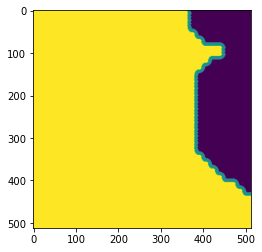

In [7]:
plt.imshow(cls[300][1])

### 3. Build the model
Adapted from [link](https://discuss.pytorch.org/t/unet-implementation/426)


In [8]:
import torch
from torch import nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv'):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels, 2**(wf+i),
                                                padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2**(wf+i), up_mode,
                                            padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path)-1:
                blocks.append(x)
                x = F.avg_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i-1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

#### Unet-params & training params
These parameters get fed directly into the UNET class, and more description of them can be discovered there

But here, I will try with epochs = 3

In [9]:
# --- unet params
#these parameters get fed directly into the UNET class, and more description of them can be discovered there

n_classes = 6    #number of classes in the data mask that we'll aim to predict


in_channels= 3  #input channel of the data, RGB = 3
padding= True   #should levels be padded
depth = 7       #depth of the network 
wf= 2           #wf (int): number of filters in the first layer is 2**wf, was 6
up_mode= 'upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

# --- training params
batch_size = 8
patch_size = 512
num_epochs = 5
edge_weight = 1.1 #edges tend to be the most poorly segmented given how little area they occupy in the training set, this paramter boosts their values along the lines of the original UNET paper
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch

### 4. Decide what divice to run the model

In [10]:
gpuid=0
#specify if we should use a GPU (cuda) or only the CPU
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(gpuid))
    torch.cuda.set_device(gpuid)
    device = torch.device(f'cuda:{gpuid}')
else:
    device = torch.device(f'cpu')

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [11]:
dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase] = PANDADataset(df)
    dataLoader[phase] = DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=8, pin_memory=True)

torch.Size([3, 512, 512]) torch.Size([512, 512])


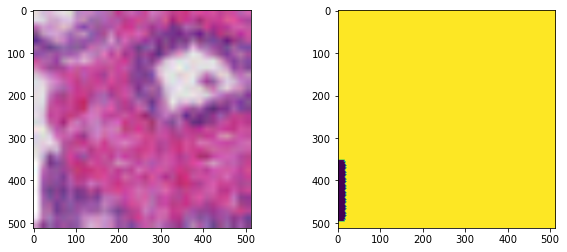

In [12]:
#visualize a single example to verify that it is correct
img, patch_mask_weight = dataset["train"][7]
fig, ax = plt.subplots(1, 2, figsize=(10,4))  # 1 row, 2 columns
print(img.shape, patch_mask_weight.shape)
#build output showing original patch  (after augmentation), class = 1 mask, weighting mask, overall mask (to see any ignored classes)
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(patch_mask_weight)
plt.show()

In [13]:
dataLoader = DataLoader(cls, batch_size=8, shuffle=True, num_workers=8)
print(len(dataLoader))
del df, cls

4500


### 5. Fit the model according to the paramters specified above and copy it to the GPU.

In [14]:
model = UNet(n_classes=n_classes, in_channels=in_channels, 
             padding=padding,depth=depth,wf=wf, 
             up_mode=up_mode, batch_norm=batch_norm).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

optim = torch.optim.Adam(model.parameters()) #adam is going to be the most robust
criterion = nn.CrossEntropyLoss(reduce=False)

total params: 	1948854


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [15]:
import time
print('======================================== Training started ========================================')
for epoch in range(num_epochs):
    print('==================================================================================================')
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    
    t0 = time.time()
    for i, data in enumerate(dataLoader, 0):
        inputs, labels = data
        inputs = inputs.to(device,dtype=torch.float) 
        labels = labels.type('torch.LongTensor').to(device)
        ##with torch.set_grad_enabled(True):
        # zero the parameter gradients
        optim.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.sum().backward()
        optim.step()
        
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels.data).sum().item()
        train_accuracy = correct_train / total_train
        
        # print statistics
        running_loss += loss.mean()
        
        
        
        if i % 100 == 99:    # print every 100 mini-batches
            t1 = time.time()
            print('Epoch %02d, upto %05d mini-batches; after %02d (minutes) and %02d (seconds);  train_loss = %.3f'%
                  (epoch + 1, i + 1, (t1 - t0) // 60, (t1 - t0)%60, running_loss / 100))
            running_loss = 0.0
print('==================================================================================================')
print('======================================== Finished Training =======================================')

======================================== Training started ========================================
Epoch 01, upto 00100 mini-batches; after 00 (minutes) and 30 (seconds);  train_loss = 1.592
Epoch 01, upto 00200 mini-batches; after 00 (minutes) and 53 (seconds);  train_loss = 1.412
Epoch 01, upto 00300 mini-batches; after 01 (minutes) and 18 (seconds);  train_loss = 1.274
Epoch 01, upto 00400 mini-batches; after 01 (minutes) and 41 (seconds);  train_loss = 1.171
Epoch 01, upto 00500 mini-batches; after 02 (minutes) and 05 (seconds);  train_loss = 1.090
Epoch 01, upto 00600 mini-batches; after 02 (minutes) and 28 (seconds);  train_loss = 1.021
Epoch 01, upto 00700 mini-batches; after 02 (minutes) and 50 (seconds);  train_loss = 1.065
Epoch 01, upto 00800 mini-batches; after 03 (minutes) and 14 (seconds);  train_loss = 1.016
Epoch 01, upto 00900 mini-batches; after 03 (minutes) and 36 (seconds);  train_loss = 1.021
Epoch 01, upto 01000 mini-batches; after 03 (minutes) and 59 (seconds);  

Epoch 02, upto 04200 mini-batches; after 16 (minutes) and 22 (seconds);  train_loss = 0.882
Epoch 02, upto 04300 mini-batches; after 16 (minutes) and 46 (seconds);  train_loss = 0.911
Epoch 02, upto 04400 mini-batches; after 17 (minutes) and 09 (seconds);  train_loss = 0.904
Epoch 02, upto 04500 mini-batches; after 17 (minutes) and 29 (seconds);  train_loss = 0.923
Epoch 03, upto 00100 mini-batches; after 00 (minutes) and 27 (seconds);  train_loss = 0.859
Epoch 03, upto 00200 mini-batches; after 00 (minutes) and 49 (seconds);  train_loss = 0.906
Epoch 03, upto 00300 mini-batches; after 01 (minutes) and 11 (seconds);  train_loss = 0.913
Epoch 03, upto 00400 mini-batches; after 01 (minutes) and 34 (seconds);  train_loss = 0.899
Epoch 03, upto 00500 mini-batches; after 01 (minutes) and 56 (seconds);  train_loss = 0.862
Epoch 03, upto 00600 mini-batches; after 02 (minutes) and 21 (seconds);  train_loss = 0.890
Epoch 03, upto 00700 mini-batches; after 02 (minutes) and 43 (seconds);  train_l

Epoch 04, upto 03900 mini-batches; after 14 (minutes) and 03 (seconds);  train_loss = 0.879
Epoch 04, upto 04000 mini-batches; after 14 (minutes) and 25 (seconds);  train_loss = 0.867
Epoch 04, upto 04100 mini-batches; after 14 (minutes) and 47 (seconds);  train_loss = 0.887
Epoch 04, upto 04200 mini-batches; after 15 (minutes) and 09 (seconds);  train_loss = 0.848
Epoch 04, upto 04300 mini-batches; after 15 (minutes) and 30 (seconds);  train_loss = 0.850
Epoch 04, upto 04400 mini-batches; after 15 (minutes) and 51 (seconds);  train_loss = 0.867
Epoch 04, upto 04500 mini-batches; after 16 (minutes) and 11 (seconds);  train_loss = 0.876
Epoch 05, upto 00100 mini-batches; after 00 (minutes) and 24 (seconds);  train_loss = 0.873
Epoch 05, upto 00200 mini-batches; after 00 (minutes) and 45 (seconds);  train_loss = 0.858
Epoch 05, upto 00300 mini-batches; after 01 (minutes) and 06 (seconds);  train_loss = 0.865
Epoch 05, upto 00400 mini-batches; after 01 (minutes) and 28 (seconds);  train_l

In [16]:
type(dataLoader)

torch.utils.data.dataloader.DataLoader

#### 4. Evaluate & predict

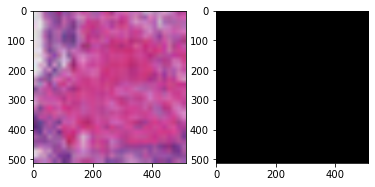

37 239 1 1


In [17]:
hdf5_dir = '/kaggle/input/h5-files/full_data_coordinate.h5'
df = dd.io.load(hdf5_dir)
cls_test = PANDADataset(df[ : 80], 1)
a = cls_test[0][0].permute((1, 2, 0)).detach().squeeze().cpu().numpy()
b = cls_test[0][1].detach().squeeze().cpu().numpy()
cmap =  matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
plt.subplot(121), plt.imshow(a)
plt.subplot(122), plt.imshow(b, cmap = cmap)
plt.show()
print(a.min(), a.max(), b.min(), b.max())

In [18]:
data_inp = []
predicts = []
true_mask = []
dataLoader_test = DataLoader(cls_test, batch_size=8, shuffle=True, num_workers=8)
for i, data in enumerate(dataLoader_test, 0):
    inputs, labels = data
    inputs = inputs.to(device,dtype = torch.float) 
    labels = labels.type('torch.LongTensor').to(device)
    predict = model(inputs)
    
    ## append
    predicts += predict
    data_inp += inputs
    true_mask += labels
    ## freeze
    del inputs, labels, predict, data
    
print(len(predicts), predicts[0].shape)
print(len(data_inp), data_inp[0].shape)
print(len(true_mask), true_mask[0].shape)

80 torch.Size([6, 512, 512])
80 torch.Size([3, 512, 512])
80 torch.Size([512, 512])


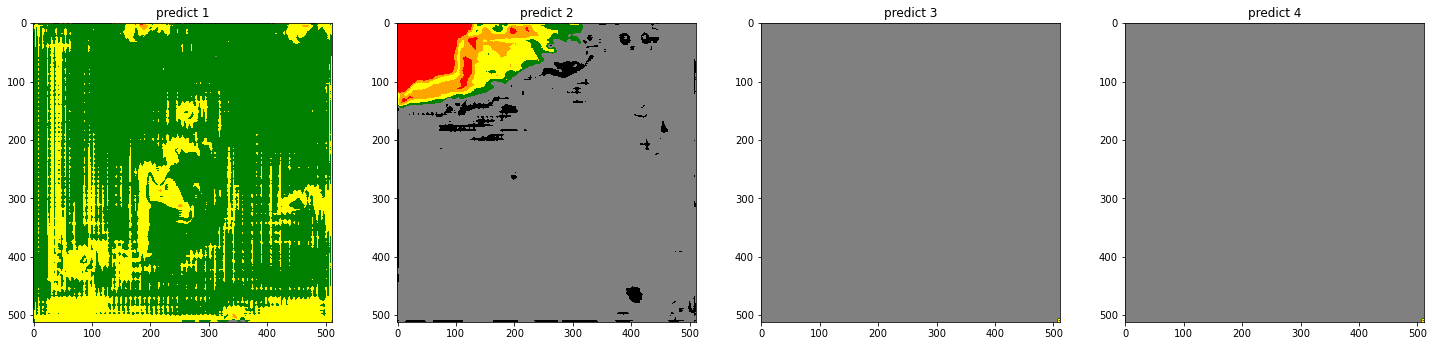

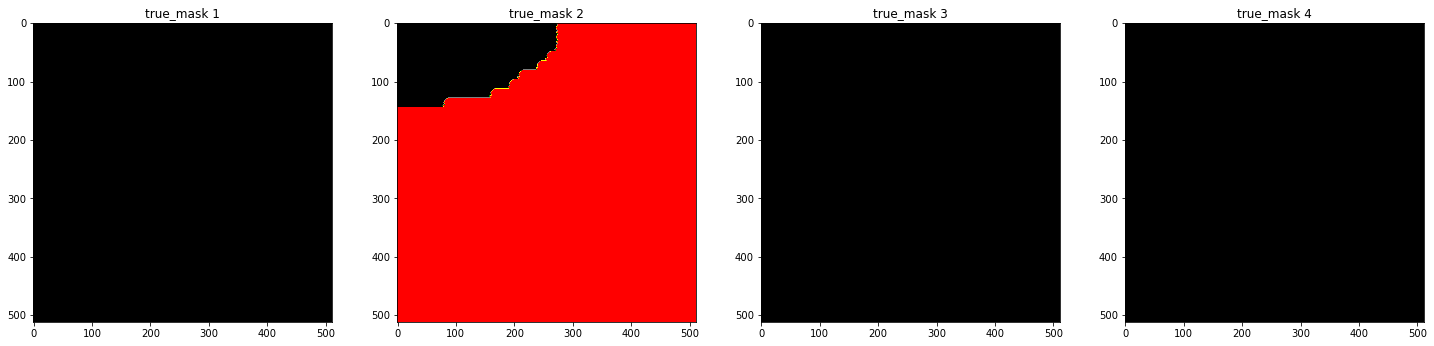

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5.5))
for k in range(4):
    c = predicts[k][0].detach().squeeze().cpu().numpy()
    ax[k].imshow(c, cmap = cmap), ax[k].set_title('predict %s'%(k+1))
plt.show()

fig, ax = plt.subplots(1, 4, figsize=(25, 5.5))
for k in range(4):
    d = true_mask[k].detach().squeeze().cpu().numpy()
    ax[k].imshow(d, cmap = cmap), ax[k].set_title('true_mask %s'%(k+1))
plt.show()

### Evaluating & grading
#### Function to make tiles from one image

In [20]:
def split_get_coordinate(img_id, crit = 0.0005, size=512, n_tiles=36):    
    """
    ==================================================================================================
    Input:  img_id (str): image_id from the train dataset, such as '004dd32d9cd167d9cc31c13b704498af'  
            crit (float) in (0, 1): the proportion of the dark_region over whole image (size 256 x 256)
            size (int) : image size
            n_tiles : number of tiles
    return: 
            list of (img_id, x_start, x_end, y_start, y_end) images size 512x512    
            ==========================================================================================
    writen by Nhan
    ==================================================================================================
    """
    img = skimage.io.MultiImage(os.path.join(data_dir, f'{img_id}.tiff'))[0]
    tile_size = 512
    h, w = img.shape[: 2]
    nc = int(w / 512)
    nr = int(h / 512)
    img_ls = []
    coord_ls = []
    S_img_tile = 512*512*3
    
    for i in range(nr):
        for j in range(nc):
            x_start, y_start = int(i*512), int(j*512)
            image_dt = img[ x_start : x_start + 512, y_start : y_start + 512 , :]
            if (image_dt.min() < 185):
                count = len(image_dt[image_dt <= 121])
                if count/(S_img_tile) >= crit:
                    image_dt = cv2.resize(image_dt, (size, size), interpolation = cv2.INTER_AREA)
                    img_ls.append(image_dt)
                    del image_dt, x_start, y_start

    ## choose n_tiles image has a best-view_range 
    img3_dt_ = np.array(img_ls)
    idxs_dt_ = np.argsort(img3_dt_.reshape(img3_dt_.shape[0],-1).sum(-1))[:n_tiles]
    
    ## attach
    list_image = []
    for final_index in idxs_dt_:
        list_image.append(img_ls[final_index])

    yield list_image

#### Funtion to calculate the isup from the list of outputs.

In [21]:
def ISUP(result):
    # result: a list of masks
    # Translation matrix of gleason scores to isup
    import numpy as np
    isup_mat = np.array([[1, 2, 4], [3, 4, 5], [4, 5, 5]])
    # calculate the most dominant gleason score
    p = np.zeros(6)
    for mask in result:
        for i in range(3, 6):
            p[i] += len(np.nonzero((mask == i)*1)) 
    gscore1 = max(np.argmax(p), 3)
    p[gscore1] = 0
    if np.argmax(p) == 0:
        gscore2 = gscore1
    else:
        gscore2 = max(np.argmax(p), 3)
        
    return isup_mat[gscore1 - 3, gscore2 - 3]

### Forecasted-scoring
#### On the train-set

In [22]:
## Taking values on image_id of the masks
ID_list = os.listdir(mask_dir)
ID_list = [u.replace('_mask.tiff', '') for u in ID_list]

## predict the first 225 values in train.csv
%time train_df_pred = pd.DataFrame({'image_id': ID_list[:225], 'isup_grade': [ISUP(split_get_coordinate(ID)) for ID in ID_list[:225]]})
train_df_pred.head()

CPU times: user 16min 2s, sys: 2min 34s, total: 18min 36s
Wall time: 21min 28s


,image_id,isup_grade
0,c699f572c40dbee492ca9ac0c1a0d9f7,5
1,78138d4fc0b8fceb04138cd44d4a4fdd,3
2,8bf80024b1a7f12ce52136af81a930df,3
3,b4f3528c1ab8e7ae2faac094cdbe06c3,3
4,1abb6882a5cba3d9c166736825bbe101,5


In [23]:
train.loc[ID_list[:225]].head()

,data_provider,isup_grade,gleason_score
image_id,,,
c699f572c40dbee492ca9ac0c1a0d9f7,karolinska,2,3+4
78138d4fc0b8fceb04138cd44d4a4fdd,radboud,5,5+4
8bf80024b1a7f12ce52136af81a930df,radboud,3,4+3
b4f3528c1ab8e7ae2faac094cdbe06c3,karolinska,3,4+3
1abb6882a5cba3d9c166736825bbe101,radboud,0,negative


#### Determine the accuraccy.

In [24]:
from sklearn.metrics import accuracy_score

y_train = train.loc[ID_list[:225]]['isup_grade']
y_pred_train = train_df_pred['isup_grade']

accuracy_score(y_train, y_pred_train)

0.35555555555555557

#### On the test-set

In [25]:
## Take value from the test_images
ID_list = [u.replace('_mask.tiff', '') for u in ID_list]

## predict
%time test_df_pred = pd.DataFrame({'image_id': ID_list[225:228], 'isup_grade': [ISUP(split_get_coordinate(ID)) for ID in ID_list[225:228]]})
test_df_pred

CPU times: user 16.5 s, sys: 2.77 s, total: 19.3 s
Wall time: 21.4 s


,image_id,isup_grade
0,12592e0c38df5d4d8222fabaeb5ed8bd,5
1,75be11818843990c70ba0b6ed753f3c0,4
2,90eafbed9a8929f535b122c7b164fcf9,3
